In [2]:
import numpy as np
import nlopt
import pandas as pd
from math import log, exp
from multiprocessing import Pool, cpu_count
import time
import matplotlib.pyplot as plt
%matplotlib notebook

In [15]:
fileIn = "/msprime_parametric_bootstrap_fixed_L_200.tsv"


In [3]:
def rho(rbp,g,L,d):
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    return(r)

In [4]:
def single_dist_obj_fun(r,x):
    d,h0,h1,h2,th = x
    r = r*(d)
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [5]:
def single_dist_multi_ind_obj_fun(r,xl):
    res = [ single_dist_obj_fun(r,xs) for xs in xl]
    res = sum(res)
    return(res)

In [6]:
def find_max_like_single_dist(args):
    d, testChr = args
    opt = nlopt.opt(nlopt.LN_NELDERMEAD,1)
    opt.set_lower_bounds([0.0001])
    opt.set_upper_bounds([0.1])
    startPoint = [0.001]
    opt.set_max_objective(lambda x, grad: single_dist_obj_fun(x,testChr))
    res = opt.optimize(startPoint)
    return(res[0])

In [7]:
def calc_single_dist(x,rbp,g,L):
    d,h0,h1,h2,th = x
    
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [8]:
def single_chr_obj_fun(x_,arr):
    rbp, g, L = x_
    test = np.apply_along_axis(lambda x: calc_single_dist(x,rbp,g,L),1,arr)
    obfun = np.sum(test)
    #test = [calc_single_dist(x,rbp,g,L) for x in arr]
    #obfun = sum(test)
    return(obfun)

In [9]:
def across_chr_obj_fun(x,dfArrList,numChrs):
    
    rList = x[0:numChrs]
    gList = x[numChrs:numChrs+numChrs]
    L = x[-1]
    
    obFun = sum([single_chr_obj_fun([rs,gs,L],arr) for (rs,gs,arr) in list(zip(rList,gList,dfArrList))])
    
    return(obFun)

In [10]:
def find_max_like_single_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [ df.loc[(df['chromosome']== x) & (df['replicate']==rep) & (df['sample']==1) & (df['Unnamed: 0']<=10)] for x in list(range(1,numberChromsomes+1))]
    dfListAuto = [x.iloc[:,[0,4,5,6,11]].to_numpy() for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [11]:
def combine_across_individuals(thisDF):
    test = thisDF
    numSamples = len(test['sample'].unique())
    test = test.groupby(['Unnamed: 0'],as_index=False).sum()
    test['H'] = test['H']/numSamples
    return(test.iloc[:,[0,4,5,6,11]].to_numpy())
    #return( test.iloc[:,[0,4,5,6,11]].to_numpy() )

In [12]:
def find_max_like_group_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [ df.loc[(df['chromosome']== x) & (df['replicate']==rep) & (df['Unnamed: 0']<=10)] for x in list(range(1,numberChromsomes+1))]
    dfListAuto = [combine_across_individuals(x) for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [13]:
def combine_across_individuals_and_replicates(thisDF):
    test = thisDF
    numSamples = len(test['sample'].unique())
    numReplicates = len(test['replicate'].unique())
    test = test.groupby(['Unnamed: 0'],as_index=False).sum()
    test['H'] = test['H']/(numSamples*numReplicates)
    return(test.iloc[:,[0,4,5,6,11]].to_numpy())
    #return( test.iloc[:,[0,4,5,6,11]].to_numpy() )

In [16]:
df = pd.read_csv(fileIn,delimiter='\t')
df = df.loc[ df['chromosome'] != 'X']
df = df.astype({'chromosome':'int64'})

/home/derek/anaconda3/envs/simulation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
df

,Unnamed: 0,sample,replicate,chromosome,h_0,h_1,h_2,total,h_0_frac,h_1_frac,h_2_frac,H
0,1,1,1,10,52288925,744471,5262,53038658,0.985864,0.014036,0.000099,0.007117
1,2,1,1,10,52289046,744227,5384,53038657,0.985867,0.014032,0.000102,0.007117
2,3,1,1,10,52288927,744463,5266,53038656,0.985864,0.014036,0.000099,0.007117
3,4,1,1,10,52288895,744525,5235,53038655,0.985864,0.014037,0.000099,0.007117
4,5,1,1,10,52288845,744623,5186,53038654,0.985863,0.014039,0.000098,0.007117
...,...,...,...,...,...,...,...,...,...,...,...,...
37999995,1996,10,100,9,45932037,651092,2949,46586078,0.985961,0.013976,0.000063,0.007051
37999996,1997,10,100,9,45931974,651216,2887,46586077,0.985959,0.013979,0.000062,0.007051
37999997,1998,10,100,9,45931930,651302,2844,46586076,0.985958,0.013981,0.000061,0.007051
37999998,1999,10,100,9,45931979,651202,2894,46586075,0.985959,0.013978,0.000062,0.007051


In [261]:
#single_dist_obj_fun(0.0014,testChr[400])
#calc_single_dist(testChr[400],0.0014,0,0)

/home/derek/anaconda3/envs/simulation/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


-4732721.749829463

Here obtaining a single estimate compositing over all distances with data pooled across individuals and replicates for chromosome 19 data only

In [1]:
testPooled = df.loc[(df['chromosome']==19) & (df['replicate']<= 100) & (df['Unnamed: 0']<=2000)] 
testPooled = combine_across_individuals_and_replicates(testPooled)

NameError: name 'df' is not defined

In [29]:

lowerBounds = [ 0.0001, 0.0001,10]
upperBounds = [ 0.1, 0.1, 2000]
startPoints = [ 0.001, 0.001, 50]

opt=nlopt.opt(nlopt.LN_NELDERMEAD,3)

opt.set_lower_bounds(lowerBounds)
opt.set_upper_bounds(upperBounds)
opt.set_max_objective(lambda x,grad: single_chr_obj_fun(x,testPooled))
res = opt.optimize(startPoints)

print([x for x in res])

[0.00147997365514947, 0.003899088222053838, 185.76350529678086]


In [32]:
testChr = 19
modelTruth = [rho(0.00144168,0.00356648,200,d+1)/(d+1) for d in list(range(0,1000))]
modelConstant = [ 0.00144168 for x in list(range(2000))]
modelEstimatedGloballyAsMedian = [rho(0.00164344,0.0038803,167.4,d+1)/(d+1) for d in list(range(0,2000))]
modelEstimatedChr19CombinedReps = [rho(0.00147997365514947,0.003899088222053838,185.76350529678086,d+1)/(d+1) for d in list(range(0,2000))]


In [33]:
print(modelTruth)

[0.008556837283552944, 0.008539093786053387, 0.008521409285929217, 0.008503783562492354, 0.008486216395935385, 0.008468707567327776, 0.00845125685861225, 0.008433864052601122, 0.008416528932972697, 0.00839925128426774, 0.008382030891885784, 0.008364867542081622, 0.00834776102196179, 0.008330711119480961, 0.008313717623438476, 0.008296780323474784, 0.008279899010068007, 0.008263073474530447, 0.008246303509005095, 0.008229588906462224, 0.008212929460695914, 0.008196324966320693, 0.008179775218768073, 0.008163280014283205, 0.008146839149921474, 0.008130452423545178, 0.008114119633820135, 0.008097840580212384, 0.008081615062984875, 0.008065442883194131, 0.008049323842686995, 0.008033257744097333, 0.008017244390842787, 0.008001283587121523, 0.007985375137909, 0.007969518848954742, 0.007953714526779147, 0.007937961978670287, 0.007922261012680735, 0.007906611437624394, 0.007891013063073351, 0.007875465699354735, 0.007859969157547603, 0.007844523249479816, 0.007829127787724951, 0.0078137825855

Here we are trying a single iteration

In [79]:
#testChr =  df.loc[(df['chromosome']== 19) & (df['replicate']==25) & (df['Unnamed: 0']<=2000)] 

testChr =  df.loc[(df['chromosome']== 19) & (df['replicate']==3) & (df['Unnamed: 0']<=2000)] 
testChr = testChr.iloc[:,[0,4,5,6,11]].to_numpy()

jobs = [[x+1,testChr[x]] for x in list(range(0,1000))]
with Pool(cpu_count()) as p:
    thisResOneInd = p.map(find_max_like_single_dist,jobs)
    
print(thisResOneInd)


[0.0912654296875196, 0.05171316528318346, 0.0394186394929984, 0.0314421745300391, 0.03445508918760242, 0.018262474060053678, 0.019594789504999967, 0.020215417480463828, 0.011355795288088388, 0.002739490303398406, 0.006668286132851789, 0.02046283645378425, 0.011339933776853009, 0.009253588867185043, 0.0036437225344940092, 0.014365403747538946, 0.012367100524897428, 0.01316404876708493, 0.010270128917696547, 0.01085975484848268, 0.01176172766684749, 0.007891224178674293, 0.012600573730478567, 0.011949901575783857, 0.013261071777338833, 0.011204945492744443, 0.006429930867784423, 0.007508740234377454, 0.006728807067873548, 0.009610215297343797, 0.008248257345706222, 0.008218975448610853, 0.012026219654080794, 0.009565628051755353, 0.012876110839848657, 0.01178531748056166, 0.010139106655123305, 0.010937556076047347, 0.008950303125383922, 0.011490432739255353, 0.010095330429079601, 0.009328856372204604, 0.00982649841308839, 0.008981368255612777, 0.009236161804118181, 0.009298948669431137, 

In [31]:
jobs = [[x+1,testChr[x]] for x in list(range(0,20))]
with Pool(cpu_count()) as p:
    thisResOneInd = p.map(find_max_like_single_dist,jobs)

In [32]:
print(thisResOneInd)

[0.1, 0.02184194319845227, 0.055164094543437354, 0.029354531860361372, 0.022727224254524656, 0.03164631423918762, 0.01498228255808844, 0.02390673103458247, 0.018239752960200167, 0.021072621440877626, 0.011715136086938305, 0.031108865218423293, 0.012216972350750071, 0.013955208607763048, 0.028322277069091788, 0.02137635650639185, 0.008185722903162239, 0.008823474100979636, 0.019296562194814387, 0.014500350833096304]


<IPython.core.display.Javascript object>


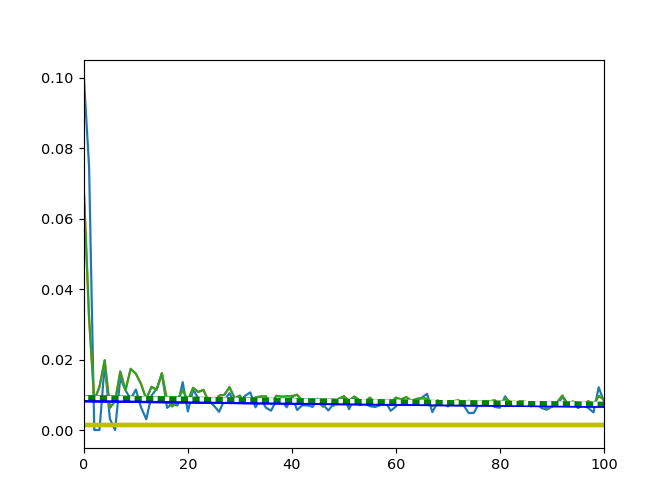

NameError: name 'modelTruth' is not defined

In [20]:
plt.plot(thisResOneInd)
plt.plot(modelTruth,"b",linewidth=3)
plt.plot(modelConstant,"y",linewidth=3)
plt.plot(modelEstimatedGloballyAsMedian,"g",linewidth=3)
plt.plot(modelEstimatedChr19CombinedReps,"w:",linewidth=3)
plt.xlim([0,100])
plt.show()

Here combining across individuals to get an estimate of Rho/d (r/bp) for each distance  

In [64]:
testPooled = df.loc[(df['chromosome']==19)  & (df['Unnamed: 0']<=2000)] 
testPooled = combine_across_individuals_and_replicates(testPooled)

In [65]:
jobs = [[x+1,testPooled[x]] for x in list(range(1000))]
with Pool(cpu_count()) as p:
    thisRes = p.map(find_max_like_single_dist,jobs)

In [66]:
print(thisRes)

[0.040595626067977696, 0.02489905395508794, 0.020335573577885763, 0.017560241377672897, 0.016256384277338838, 0.014501483154301784, 0.014610391998286102, 0.013166973555088042, 0.012492210769648406, 0.011877742004392074, 0.011626630592348645, 0.011457558727266857, 0.010521031761171886, 0.01045898131067424, 0.010590343797209332, 0.01071787414551272, 0.010789807128903792, 0.01003608150474565, 0.010062896728201303, 0.009645182800275778, 0.009767543029704121, 0.01024866180419676, 0.009942466402051372, 0.009715194892568977, 0.00977323877431045, 0.00939417953365482, 0.009622235107419417, 0.00943905396461241, 0.00939747542329378, 0.00922728388137184, 0.009285271012780594, 0.00913535881105099, 0.009286846522239371, 0.00889245108553259, 0.009100587081909178, 0.00897553992208559, 0.009115593719479967, 0.008866197365836707, 0.008912245798108506, 0.00882149529441376, 0.00888844451904051, 0.009023401260378431, 0.008445764160158704, 0.008682696771619248, 0.00862551550864928, 0.008631436538698745, 0.0

<IPython.core.display.Javascript object>


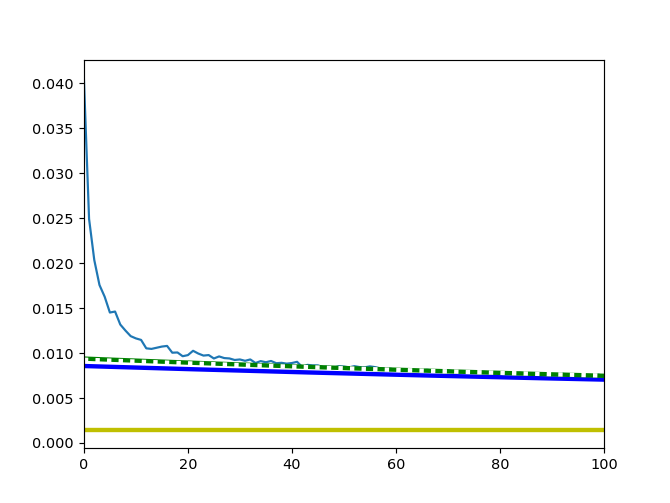

In [67]:
plt.plot(thisRes)
plt.plot(modelTruth,"b",linewidth=3)
plt.plot(modelConstant,"y",linewidth=3)
plt.plot(modelEstimatedGloballyAsMedian,"g",linewidth=3)
plt.plot(modelEstimatedChr19CombinedReps,"w:",linewidth=3)
plt.xlim([0,100])
plt.show()